<a href="https://colab.research.google.com/github/ajeyamk/causalvae/blob/dev-ajeya/causal_vae_dsprites.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Deep Causal Variational Inference

### Introduction:
To train a supervised variational autoencoder using Deepmind's [dSprites](https://github.com/deepmind/dsprites-dataset) dataset.

dSprites is a dataset of sprites, which are 2D shapes procedurally generated from 5 ground truth independent "factors." These factors are color, shape, scale, rotation, x and y positions of a sprite.

All possible combinations of these variables are present exactly once, generating N = 737280 total images.

Factors and their values:

* Shape: 3 values {square, ellipse, heart}
* Scale: 6 values linearly spaced in (0.5, 1)
* Orientation: 40 values in (0, 2$\pi$)
* Position X: 32 values in (0, 1)
* Position Y: 32 values in (0, 1)


Further, the objective of any generative model is essentially to capture underlying data generative factors, the disentangled representation would mean a single latent unit being sensitive to variations in single generative factors


### Goal:
To include the latent factors  as labels in the training and to invent a causal story that relates these factors and the images in a DAG.

Reference 

[Structured Disentangled Representation](https://arxiv.org/pdf/1804.02086.pdf)

In [1]:
#Install dependencies
!pip3 install pyro-ppl
!pip3 install torch torchvision
!pip3 install pydrive --upgrade
!pip3 install tqdm

     |████████████████████████████████| 276kB 2.8MB/s 
     |████████████████████████████████| 61kB 11.2MB/s 
     |████████████████████████████████| 748.9MB 24kB/s 
     |████████████████████████████████| 51kB 20.7MB/s 
  Created wheel for pyro-ppl: filename=pyro_ppl-0.4.0-cp36-none-any.whl size=370752 sha256=25ebfcf748b80b4202b301d41adc4028dab99dfe9c2253d506e952fa75b45593
  Stored in directory: /root/.cache/pip/wheels/14/1a/a9/896e3cb73f56729c480545be63fd5073933ed7fe604d4f4e74
  Created wheel for opt-einsum: filename=opt_einsum-2.3.2-cp36-none-any.whl size=49882 sha256=cf0172eb5556a49bebef48577a71f875a3bcb3df6503aa49befe2cb561912868
  Stored in directory: /root/.cache/pip/wheels/51/3e/a3/b351fae0cbf15373c2136a54a70f43fea5fe91d8168a5faaa4
Successfully built pyro-ppl opt-einsum
  Found existing installation: torch 1.1.0
    Uninstalling torch-1.1.0:
      Successfully uninstalled torch-1.1.0
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uni

     |████████████████████████████████| 993kB 2.9MB/s 
  Created wheel for pydrive: filename=PyDrive-1.3.1-cp36-none-any.whl size=27435 sha256=8ee22f5d638f7383ffc91e081f83cfb07f4b75fb67a0ce09d44301ff13754ce6
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built pydrive


In [0]:
# Load necessary libraries
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

import os
from collections import defaultdict

import torch
# import torchvision.datasets as dset
import torch.nn as nn
# import torchvision.transforms as transforms
from tqdm import tqdm
import pyro
# from pyro.contrib.examples.util import print_and_log
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate
from pyro.optim import Adam, SGD
import torch.distributions.constraints as constraints

# Change figure aesthetics
%matplotlib inline
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 1.5})

#to utilize GPU capabilities
USE_CUDA = True

pyro.enable_validation(True)
pyro.distributions.enable_validation(False)

In [3]:
# Mount Google drive to load data
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Mount G drive to access files
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
# Hack to get all available GPU ram.

import tensorflow as tf
tf.test.gpu_device_name()

!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7411 sha256=0d24c5371ac57c360cbdf9a5c099e28efdcb861032c61669b25195f408208a0e
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 25.1 GB  | Proc size: 2.2 GB
GPU RAM Free: 11111MB | Used: 330MB | Util   3% | Total 11441MB


In [0]:
class Encoder(nn.Module):
	def __init__(self, image_dim, label_dim, z_dim):
		super(Encoder, self).__init__()
		#setup image and label dimensions from the dataset
		self.image_dim = image_dim
		self.label_dim = label_dim
		self.z_dim = z_dim
		# setup the three linear transformations used
		self.fc1 = nn.Linear(self.image_dim+self.label_dim, 1000)
		self.fc2 = nn.Linear(1000, 1000)
		self.fc31 = nn.Linear(1000, z_dim)  # mu values
		self.fc32 = nn.Linear(1000, z_dim)  # sigma values
		# setup the non-linearities
		self.softplus = nn.Softplus()

	def forward(self, xs, ys):
		xs = xs.reshape(-1, self.image_dim)
		#now concatenate the image and label
		inputs = torch.cat((xs,ys), -1)
		# then compute the hidden units
		hidden1 = self.softplus(self.fc1(inputs))
		hidden2 = self.softplus(self.fc2(hidden1))
		# then return a mean vector and a (positive) square root covariance
		# each of size batch_size x z_dim
		z_loc = self.fc31(hidden2)
		z_scale = torch.exp(self.fc32(hidden2))
		return z_loc, z_scale

class Decoder(nn.Module):
	def __init__(self, image_dim, label_dim, z_dim):
		super(Decoder, self).__init__()
		# setup the two linear transformations used
		hidden_dim = 1000
		self.fc1 = nn.Linear(z_dim+label_dim, hidden_dim)
		self.fc2 = nn.Linear(hidden_dim, hidden_dim)
		self.fc3 = nn.Linear(hidden_dim, hidden_dim)
		self.fc4 = nn.Linear(hidden_dim, image_dim)
		# setup the non-linearities
		self.softplus = nn.Softplus()
		self.sigmoid = nn.Sigmoid()

	def forward(self, zs, ys):
		inputs = torch.cat((zs, ys),-1)
		# then compute the hidden units
		hidden1 = self.softplus(self.fc1(inputs))
		hidden2 = self.softplus(self.fc2(hidden1))
		hidden3 = self.softplus(self.fc3(hidden2))
		# return the parameter for the output Bernoulli
		# each is of size batch_size x 784
		loc_img = self.sigmoid(self.fc4(hidden3))
		return loc_img

In [0]:
class CVAE(nn.Module):
	def __init__(self, config_enum=None, use_cuda=False, aux_loss_multiplier=None):
		super(CVAE, self).__init__()
		self.image_dim = 64**2
		self.label_shape = np.array((1,3,6,40,32,32))
		self.label_names = np.array(('color', 'shape', 'scale', 'orientation', 'posX', 'posY'))
		self.label_dim = np.sum(self.label_shape)
		self.z_dim = 50                                           
		self.allow_broadcast = config_enum == 'parallel'
		self.use_cuda = use_cuda
		self.aux_loss_multiplier = aux_loss_multiplier
    # define and instantiate the neural networks representing
    # the paramters of various distributions in the model
		self.setup_networks()

	def setup_networks(self):
		self.encoder = Encoder(self.image_dim, self.label_dim, self.z_dim)
		self.decoder = Decoder(self.image_dim, self.label_dim, self.z_dim)
		# using GPUs for faster training of the networks
		if self.use_cuda:
		    self.cuda()

	def model(self, xs, ys):
		pyro.module("cvae", self)
		batch_size = xs.size(0)
		options = dict(dtype=xs.dtype, device=xs.device)
		with pyro.plate("data"):
			prior_loc = torch.zeros(batch_size, self.z_dim, **options)
			prior_scale = torch.ones(batch_size, self.z_dim, **options)
			zs = pyro.sample("z", dist.Normal(prior_loc, prior_scale).to_event(1))
			# if the label y (which digit to write) is supervised, sample from the
			# constant prior, otherwise, observe the value (i.e. score it against the constant prior)
			loc = self.decoder.forward(zs, self.remap_y(ys))
			pyro.sample("x", dist.Bernoulli(loc).to_event(1), obs=xs)
		  # return the loc so we can visualize it later
			return loc

	def guide(self, xs, ys):
		with pyro.plate("data"):
      # sample (and score) the latent handwriting-style with the variational
      # distribution q(z|x) = normal(loc(x),scale(x))
			loc, scale = self.encoder.forward(xs, self.remap_y(ys))
			pyro.sample("z", dist.Normal(loc, scale).to_event(1))

	def remap_y(self, ys):
		new_ys = []
		options = dict(dtype=ys.dtype, device=ys.device)
		for i, label_length in enumerate(self.label_shape):
		    prior = torch.ones(ys.size(0), label_length, **options) / (1.0 * label_length)
		    new_ys.append(pyro.sample("y_%s" % self.label_names[i], dist.OneHotCategorical(prior), 
		                           obs=torch.nn.functional.one_hot(ys[:,i].to(torch.int64), int(label_length))))
		new_ys = torch.cat(new_ys, -1)
		return new_ys.to(torch.float32)

	def reconstruct_image(self, xs, ys):
	  # backward
		sim_z_loc, sim_z_scale = self.encoder.forward(xs, self.remap_y(ys))
		zs = dist.Normal(sim_z_loc, sim_z_scale).to_event(1).sample()
		# forward
		loc = self.decoder.forward(zs, self.remap_y(ys))
		return dist.Bernoulli(loc).to_event(1).sample()

In [0]:
def setup_data_loaders(train_x, test_x, train_y, test_y, batch_size=128, use_cuda=False):
	train_dset = torch.utils.data.TensorDataset(
	  torch.from_numpy(train_x.astype(np.float32)).reshape(-1, 4096),
	  torch.from_numpy(train_y.astype(np.float32))
	)
	test_dset = torch.utils.data.TensorDataset(
	  torch.from_numpy(test_x.astype(np.float32)).reshape(-1, 4096),
	  torch.from_numpy(test_y.astype(np.float32))
	)    
	kwargs = {'num_workers': 1, 'pin_memory': use_cuda}
	train_loader = torch.utils.data.DataLoader(
	  dataset=train_dset, batch_size=batch_size, shuffle=False, **kwargs
	)

	test_loader = torch.utils.data.DataLoader(
	  dataset=test_dset, batch_size=batch_size, shuffle=False, **kwargs
	)
	return {"train":train_loader, "test":test_loader}

In [0]:
dataset_zip = np.load(
    '/content/gdrive/My Drive/data-science/causal-ml/projects/dsprites-dataset/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz',
    encoding = 'bytes',
    allow_pickle=True
)

imgs = dataset_zip['imgs']
labels = dataset_zip['latents_classes']
label_sizes = dataset_zip['metadata'][()][b'latents_sizes']
label_names = dataset_zip['metadata'][()][b'latents_names']

# Sample imgs randomly
indices_sampled = np.arange(imgs.shape[0])
np.random.shuffle(indices_sampled)
imgs_sampled = imgs[indices_sampled]
labels_sampled = labels[indices_sampled]

data_loaders = setup_data_loaders(
    imgs_sampled[1000:],
    imgs_sampled[:1000],
    labels_sampled[1000:],
    labels_sampled[:1000],
    batch_size=256,
    use_cuda=USE_CUDA
)

In [0]:
def train(svi, train_loader, use_cuda=False):
	# initialize loss accumulator
	epoch_loss = 0.
	# do a training epoch over each mini-batch x returned
	# by the data loader
	for xs,ys in train_loader:
	  # if on GPU put mini-batch into CUDA memory
	  if use_cuda:
	      xs = xs.cuda()
	      ys = ys.cuda()
	  # do ELBO gradient and accumulate loss
	  epoch_loss += svi.step(xs, ys)
	# return epoch loss
	normalizer_train = len(train_loader.dataset)
	total_epoch_loss_train = epoch_loss / normalizer_train
	return total_epoch_loss_train

def evaluate(svi, test_loader, use_cuda=False):
	# initialize loss accumulator
	test_loss = 0.
	# compute the loss over the entire test set
	for xs, ys in test_loader:
	  # if on GPU put mini-batch into CUDA memory
	  if use_cuda:
	      xs = xs.cuda()
	      ys = ys.cuda()
	  # compute ELBO estimate and accumulate loss
	  test_loss += svi.evaluate_loss(xs, ys)
	normalizer_test = len(test_loader.dataset)
	total_epoch_loss_test = test_loss / normalizer_test
	return total_epoch_loss_test

In [0]:
# Run options
LEARNING_RATE = 1.0e-3

# Run only for a single iteration for testing
NUM_EPOCHS = 10
TEST_FREQUENCY = 5

In [12]:
#################################
### FOR SAVING AND LOADING MODEL
################################
# clear param store

pyro.clear_param_store()

network_path = "/content/gdrive/My Drive/data-science/causal-ml/projects/trained_model.save"

PATH = "trained_model.save"

# new model
# vae = CVAE(use_cuda=USE_CUDA)

# save current model
# torch.save(vae.state_dict(), PATH)

# to load params from trained model
vae = CVAE(use_cuda=USE_CUDA)
vae.load_state_dict(torch.load(network_path))

<All keys matched successfully>

### **DONT RUN THE BELOW CODE AS WE'VE ALREADY TRAINED THE MODEL AND WE'VE STORED THE NETWORK PARAMS**

## ==================================================================================

In [0]:
import warnings
warnings.filterwarnings('ignore')

# clear param store
pyro.clear_param_store()

# setup the VAE
vae = CVAE(use_cuda=USE_CUDA)

# setup the optimizer
adam_args = {"lr": LEARNING_RATE}
optimizer = Adam(adam_args)

# setup the inference algorithm
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

train_elbo = []
test_elbo = []
# training loop

VERBOSE = True
pbar = tqdm(range(NUM_EPOCHS))
for epoch in pbar:
    total_epoch_loss_train = train(svi, data_loaders["train"], use_cuda=USE_CUDA)
    train_elbo.append(-total_epoch_loss_train)
    if VERBOSE:
        print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))
    if epoch % TEST_FREQUENCY == 0:
        # report test diagnostics
        total_epoch_loss_test = evaluate(svi, data_loaders["test"], use_cuda=USE_CUDA)
        test_elbo.append(-total_epoch_loss_test)
        if VERBOSE:
            print("[epoch %03d] average test loss: %.4f" % (epoch, total_epoch_loss_test))

## ==================================================================================

#### Visualizing the reconstruction accuracy

In [0]:
# [ 0,  2,  1, 34,  4, 24]
def recon_check(original, recon):
  fig = plt.figure()
  ax0 = fig.add_subplot(121)
  plt.imshow(original, cmap='Greys_r',  interpolation='nearest')
  plt.axis('off')
  ax1 = fig.add_subplot(122)
  plt.imshow(recon , cmap='Greys_r', interpolation='nearest')
  plt.axis('off')
    

def show_density(img1, img2):
  fig = plt.figure()
  ax0 = fig.add_subplot(121)
  plt.imshow(img1.mean(axis=0), cmap='Greys_r',  interpolation='nearest')
  plt.axis('off')
  ax1 = fig.add_subplot(122)
  plt.imshow(img2.mean(axis=0) , cmap='Greys_r', interpolation='nearest')
  plt.axis('off')
  
  
def show_density2(imgs):
  _, ax = plt.subplots()
  ax.imshow(imgs.mean(), interpolation='nearest', cmap='Greys_r')
  ax.grid('off')
  ax.set_xticks([])
  ax.set_yticks([])
  

latents_bases = np.concatenate((label_sizes[::-1].cumprod()[::-1][1:],
                                np.array([1,])))

def latent_to_index(latents):
  return np.dot(latents, latents_bases).astype(int)

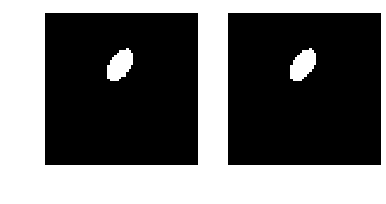

In [14]:
import warnings
warnings.filterwarnings("ignore")

data_iter = iter(data_loaders["train"])
xs, ys = next(data_iter)

if USE_CUDA:
    xs = xs.cuda()
    ys = ys.cuda()
rs = vae.reconstruct_image(xs, ys)
if USE_CUDA:
    xs = xs.cpu()
    rs = rs.cpu()
originals = xs.numpy().reshape(-1, 64,64)
recons = rs.reshape(-1,64,64)

recon_check(originals[0], recons[0])

In [15]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def f(x):
    fig = plt.figure()
    ax0 = fig.add_subplot(121)
    plt.imshow(originals[x], cmap='Greys_r',  interpolation='nearest')
    plt.axis('off')
    ax1 = fig.add_subplot(122)
    plt.imshow(recons[x], cmap='Greys_r',  interpolation='nearest')
    plt.axis('off')
    
interact(f, x=widgets.IntSlider(min=0, max=xs.shape[0], step=1, value=0))

interactive(children=(IntSlider(value=0, description='x', max=256), Output()), _dom_classes=('widget-interact'…

<function __main__.f>

In [17]:
y_names = ['shape', 'scale', 'orientation', 'posX', 'posY']
y_shapes = np.array((3,6,40,32,32))
img_dict = {}

for i, img in enumerate(imgs_sampled):
     img_dict[tuple(labels_sampled[i])] = img

def find_in_dataset(shape, scale, orient, posX, posY):
  fig = plt.figure()
  img = img_dict[(0, shape, scale, orient, posX, posY)]
  plt.imshow(img.reshape(64,64), cmap='Greys_r', interpolation='nearest')
  plt.axis('off')

interact(find_in_dataset, 
         shape=widgets.IntSlider(min=0, max=2, step=1, value=0),
         scale=widgets.IntSlider(min=0, max=5, step=1, value=0),
         orient=widgets.IntSlider(min=0, max=39, step=1, value=0),
         posX=widgets.IntSlider(min=0, max=31, step=1, value=0),
         posY=widgets.IntSlider(min=0, max=31, step=1, value=0))

interactive(children=(IntSlider(value=0, description='shape', max=2), IntSlider(value=0, description='scale', …

<function __main__.find_in_dataset>

In [0]:
def OldSCM(vae, mu, sigma):
    z_dim = vae.z_dim
    Ny, Y, ys = [], [], []
    Nx = pyro.sample("Nx", dist.Uniform(torch.zeros(vae.image_dim), torch.ones(vae.image_dim)))
    Nz = pyro.sample("Nz", dist.Normal(torch.zeros(z_dim), torch.ones(z_dim)))
    m = torch.distributions.gumbel.Gumbel(torch.tensor(0.0), torch.tensor(1.0))
    for label_id in range(6):
        name = vae.label_names[label_id]
        length = vae.label_shape[label_id]
        new = pyro.sample("Ny_%s"%name, dist.Uniform(torch.zeros(length), torch.ones(length)) )
        Ny.append(new)
        gumbel_vars = torch.tensor([m.sample() for _ in range(length)])
        max_ind = torch.argmax(torch.log(new) + gumbel_vars).item()
        Y.append(pyro.sample("Y_%s"%name, dist.Normal(torch.tensor(max_ind * 1.0), 1e-4)))
#         Y.append(pyro.sample("Y_%s"%name, dist.Delta(torch.tensor(max_ind*1.0))))
        ys.append(torch.nn.functional.one_hot(torch.tensor(max_ind), int(length)))  
    Y = torch.tensor(Y)
    ys = torch.cat(ys).to(torch.float32).reshape(1,-1).cuda()
    Z = pyro.sample("Z", dist.Normal(mu + Nz*sigma, 1e-4))
#     Z = pyro.sample("Z", dist.Delta(mu + Nz*sigma))
    zs = Z.cuda()
    p = vae.decoder.forward(zs,ys)
    X = pyro.sample("X", dist.Normal((Nx < p.cpu()).type(torch.float), 1e-4))
#     X = pyro.sample("X", dist.Delta((Nx < p.cpu()).type(torch.float)))
    return X, Y, Z

In [20]:
import warnings
warnings.filterwarnings("ignore")

xs, ys = next(data_iter)
x = xs[0].reshape(1,-1).cuda()
y = ys[0].reshape(1,-1).cuda()
mu, sigma = vae.encoder.forward(x,vae.remap_y(y))
mu = mu.cpu()
sigma = sigma.cpu()
recon_x1, y1, z1 = OldSCM(vae, mu, sigma)
print(y1)

tensor([-1.9289e-05,  9.9998e-01,  5.0000e+00,  2.3000e+01,  1.1000e+01,
         2.3000e+01])


tensor([-1.0688e-04,  0.0000e+00,  3.0000e+00,  8.0001e+00,  2.7000e+01,
         2.9000e+01])


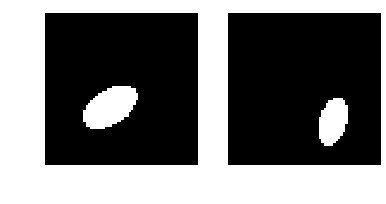

In [22]:
from pyro.infer.importance import Importance
from pyro.infer.mcmc import MCMC
from pyro.infer.mcmc.nuts import HMC
from pyro.infer import SVI

intervened_model = pyro.do(OldSCM, data={"Y_shape": torch.tensor(0.)})
conditioned_model = pyro.condition(OldSCM, data={
    "X": recon_x1,
#     "Z": z1,
    "Y_color":y1[0],
    "Y_shape": y1[1],
    "Y_scale": y1[2],
    "Y_orientation": y1[3],
    "Y_posX": y1[4],
    "Y_posY": y1[5]
   })

#  change to svi
posterior = pyro.infer.Importance(conditioned_model, num_samples = 100)
posterior.run(vae, mu, sigma)

result = []
for i in range(500):
  trace = posterior()
  x = trace.nodes['Nx']['value']
  ny_shape = trace.nodes['Ny_shape']['value']
  ny_scale = trace.nodes['Ny_scale']['value']
  ny_orientation = trace.nodes['Ny_orientation']['value']
  ny_posX = trace.nodes['Ny_posX']['value']
  ny_posY = trace.nodes['Ny_posY']['value']
  z = trace.nodes['Nz']['value']
  con_obj = pyro.condition(intervened_model, data = {
      "Nx": x,
      "Ny_shape": ny_shape, 
      "Ny_scale": ny_scale, 
      "Ny_orientation": ny_orientation, 
      "Ny_posX": ny_posX, 
      "Ny_posY": ny_posY, 
      "Nz": z
  })
  
recon_x2,y2,z2 = con_obj(vae, mu, sigma)
print(y2)
recon_check(recon_x1.reshape(-1, 64, 64)[0], recon_x2.reshape(-1, 64, 64)[0])

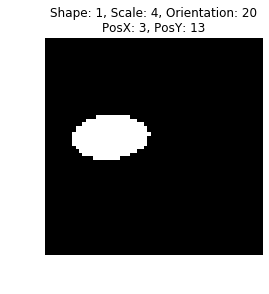

In [23]:
def get_specific_data(args=dict(), cuda=False):
    '''
    use this function to get examples of data with specific class labels
    inputs: 
        args - dictionary whose keys can include {shape, scale, orientation,
                posX, posY} and values can include any integers less than the 
                corresponding size of that label dimension
        cuda - bool to indicate whether the output should be placed on GPU
    '''
    names_dict = {'shape': 1, 'scale': 2, 'orientation': 3, 'posX': 4, 'posY': 5}
    selected_ind = np.ones(imgs.shape[0], dtype=bool)
    for k,v in args.items():
        col_id = names_dict[k]
        selected_ind = np.bitwise_and(selected_ind, labels[:, col_id] == v)
    ind = np.random.choice(np.arange(imgs.shape[0])[selected_ind])
    x = torch.from_numpy(imgs[ind].reshape(1,64**2).astype(np.float32))
    y = torch.from_numpy(labels[ind].reshape(1,6).astype(np.float32))
    if not cuda:
        return x,y
    x = x.cuda()
    y = y.cuda()
    return x,y

def plot_image(x):
    x = x.cpu()
    plt.figure()
    plt.imshow(x.reshape(64,64), interpolation='nearest', cmap='Greys_r')
    plt.axis('off')

def see_specific_image(args=dict(), verbose=True):
    '''
    use this function to get examples of data with specific class labels
    inputs: 
        args - dictionary whose keys can include {shape, scale, orientation,
                posX, posY} and values can include any integers less than the 
                corresponding size of that label dimension
        verbose - bool to indicate whether the full class label should be written 
                    as the title of the plot
    '''
    x,y = get_specific_data(args, cuda=False)
    plot_image(x)
    if verbose:
        string = ''
        for i, s in enumerate(['Shape', 'Scale', 'Orientation', 'PosX', 'PosY']):
            string += '%s: %d, ' % (s, int(y[0][i+1]))
            if i == 2:
                string = string[:-2] + '\n'
        plt.title(string[:-2], fontsize=12)
        
def compare_reconstruction(original, recon):
    """
    compare two images side by side
    inputs:
        original - array for original image
        recon - array for recon image
    """
    fig = plt.figure()
    ax0 = fig.add_subplot(121)
    plt.imshow(original.cpu().reshape(64,64), cmap='Greys_r',  interpolation='nearest')
    plt.axis('off')
    plt.title('original')
    ax1 = fig.add_subplot(122)
    plt.imshow(recon.cpu().reshape(64,64), cmap='Greys_r',  interpolation='nearest')
    plt.axis('off')
    plt.title('reconstruction')
    
def compare_to_density(original, recons):
    """
    compare two images side by side
    inputs:
        original - array for original image
        recon - array of multiple recon images
    """
    fig = plt.figure()
    ax0 = fig.add_subplot(121)
    plt.imshow(original.cpu().reshape(64,64), cmap='Greys_r',  interpolation='nearest')
    plt.axis('off')
    plt.title('original')
    ax1 = fig.add_subplot(122)
    plt.imshow(torch.mean(recons.cpu(), 0).reshape(64,64), cmap='Greys_r',  interpolation='nearest')
    plt.axis('off')
    plt.title('reconstructions')

        
see_specific_image()

In [24]:
label_dims = vae.label_shape
label_dim_offsets = np.cumsum(label_dims)
label_dim_offsets

array([  1,   4,  10,  50,  82, 114])

In [0]:
class SCM():
    def __init__(self, vae, mu, sigma):
        self.vae = vae
        self.image_dim = vae.image_dim
        self.z_dim = vae.z_dim
        
        # these are used for f_X
        self.label_dims = vae.label_shape
        
        def f_X(Y, Z, N):
            zs = Z.cuda()
            
            # convert the labels to one hot
            ys = [torch.tensor([0])]
            ys.append(torch.nn.functional.one_hot(torch.tensor(Y[0]), int(self.label_dims[1])))
            ys.append(torch.nn.functional.one_hot(torch.tensor(Y[1]), int(self.label_dims[2])))
            ys.append(torch.nn.functional.one_hot(torch.tensor(Y[2]), int(self.label_dims[3])))
            ys.append(torch.nn.functional.one_hot(torch.tensor(Y[3]), int(self.label_dims[4])))
            ys.append(torch.nn.functional.one_hot(torch.tensor(Y[4]), int(self.label_dims[5])))
            ys = torch.cat(ys).to(torch.float32).reshape(1,-1).cuda()
            
            p = vae.decoder.forward(zs, ys)
            return (N < p.cpu()).type(torch.float)
        
        def f_Y(N):
            m = torch.distributions.gumbel.Gumbel(torch.zeros(N.size(0)), torch.ones(N.size(0)))
            return torch.argmax(torch.add(torch.log(N), m.sample())).item()
        
        def f_Z(N):
            return N * sigma + mu
        
        def model(noise): 
            N_X = pyro.sample( 'N_X', noise['N_X'].to_event(1) )
            # denoted using the index in the sequence 
            # that they are stored in as vae.label_names:
            # ['shape', 'scale', 'orientation', 'posX', 'posY']
            N_Y_1 = pyro.sample( 'N_Y_1', noise['N_Y_1'].to_event(1) )
            N_Y_2 = pyro.sample( 'N_Y_2', noise['N_Y_2'].to_event(1) )
            N_Y_3 = pyro.sample( 'N_Y_3', noise['N_Y_3'].to_event(1) )
            N_Y_4 = pyro.sample( 'N_Y_4', noise['N_Y_4'].to_event(1) )
            N_Y_5 = pyro.sample( 'N_Y_5', noise['N_Y_5'].to_event(1) )
            N_Z = pyro.sample( 'N_Z', noise['N_Z'].to_event(1) )

            Z = pyro.sample('Z', dist.Normal( f_Z( N_Z ), 1e-1).to_event(1) )
            Y_1_mu = f_Y(N_Y_1)
            Y_2_mu = f_Y(N_Y_2)
            Y_3_mu = f_Y(N_Y_3)
            Y_4_mu = f_Y(N_Y_4)
            Y_5_mu = f_Y(N_Y_5)
            Y_1 = pyro.sample('Y_1', dist.Normal( Y_1_mu, 1e-1) )
            Y_2 = pyro.sample('Y_2', dist.Normal( Y_2_mu, 1e-1) )
            Y_3 = pyro.sample('Y_3', dist.Normal( Y_3_mu, 1e-1) )
            Y_4 = pyro.sample('Y_4', dist.Normal( Y_4_mu, 1e-1) )
            Y_5 = pyro.sample('Y_5', dist.Normal( Y_5_mu, 1e-1) )
            Y_mu = (Y_1_mu, Y_2_mu, Y_3_mu, Y_4_mu, Y_5_mu)
            X = pyro.sample('X', dist.Normal( f_X( Y_mu, Z, N_X ), 1e-1).to_event(1))

            noise_samples = N_X, (N_Y_1, N_Y_2, N_Y_3, N_Y_4, N_Y_5), N_Z
            variable_samples = X, (Y_1, Y_2, Y_3, Y_4, Y_5), Z

            return variable_samples, noise_samples
        
        self.model = model
        
        self.init_noise = {
            'N_X'   : dist.Uniform(torch.zeros(vae.image_dim), torch.ones(vae.image_dim)),
            'N_Z'   : dist.Normal(torch.zeros(vae.z_dim), torch.ones(vae.z_dim)),
            'N_Y_1' : dist.Uniform(torch.zeros(label_dims[1]),torch.ones(self.label_dims[1])),
            'N_Y_2' : dist.Uniform(torch.zeros(label_dims[2]),torch.ones(self.label_dims[2])),
            'N_Y_3' : dist.Uniform(torch.zeros(label_dims[3]),torch.ones(self.label_dims[3])),
            'N_Y_4' : dist.Uniform(torch.zeros(label_dims[4]),torch.ones(self.label_dims[4])),
            'N_Y_5' : dist.Uniform(torch.zeros(label_dims[5]),torch.ones(self.label_dims[5]))            
        }
        
        
        
    def update_noise_svi(self, obs_data):
        # assume all noise variables are normal distributions
        # use svi to find out the mu, sigma of the distributions
        # for the condition outlined in obs_data
        
        def guide(noise):
            # create params with constraints
            mu = {'N_X': pyro.param('N_X_mu', 0.5*torch.ones(self.image_dim),
                                    constraint = constraints.interval(0., 1.)),
                  'N_Z': pyro.param('N_Z_mu', torch.zeros(self.z_dim),
                                    constraint = constraints.interval(-3., 3.)),
                  'N_Y_1': pyro.param('N_Y_1_mu', 0.5*torch.ones(self.label_dims[1]),
                                    constraint = constraints.interval(0., 1.)),
                  'N_Y_2': pyro.param('N_Y_2_mu', 0.5*torch.ones(self.label_dims[2]),
                                    constraint = constraints.interval(0., 1.)),
                  'N_Y_3': pyro.param('N_Y_3_mu', 0.5*torch.ones(self.label_dims[3]),
                                    constraint = constraints.interval(0., 1.)),
                  'N_Y_4': pyro.param('N_Y_4_mu', 0.5*torch.ones(self.label_dims[4]),
                                    constraint = constraints.interval(0., 1.)),
                  'N_Y_5': pyro.param('N_Y_5_mu', 0.5*torch.ones(self.label_dims[5]),
                                    constraint = constraints.interval(0., 1.))
                }
            sigma = {'N_X': pyro.param('N_X_sigma', 0.1*torch.ones(self.image_dim),
                                    constraint = constraints.interval(0.0001, 0.5)),
                      'N_Z': pyro.param('N_Z_sigma', torch.ones(self.z_dim),
                                        constraint = constraints.interval(0.0001, 3.)),
                      'N_Y_1': pyro.param('N_Y_1_sigma', 0.1*torch.ones(self.label_dims[1]),
                                        constraint = constraints.interval(0.0001, 0.5)),
                      'N_Y_2': pyro.param('N_Y_2_sigma', 0.1*torch.ones(self.label_dims[2]),
                                        constraint = constraints.interval(0.0001, 0.5)),
                      'N_Y_3': pyro.param('N_Y_3_sigma', 0.1*torch.ones(self.label_dims[3]),
                                        constraint = constraints.interval(0.0001, 0.5)),
                      'N_Y_4': pyro.param('N_Y_4_sigma', 0.1*torch.ones(self.label_dims[4]),
                                        constraint = constraints.interval(0.0001, 0.5)),
                      'N_Y_5': pyro.param('N_Y_5_sigma', 0.1*torch.ones(self.label_dims[5]),
                                    constraint = constraints.interval(0.0001, 0.5))
                }
            for noise_term in noise.keys():
                pyro.sample(noise_term, dist.Normal(mu[noise_term], sigma[noise_term]).to_event(1))
        
                
        
        obs_model = pyro.condition(self.model, obs_data)

        pyro.clear_param_store()
        svi = SVI(
            model= obs_model,
            guide= guide,
            optim= SGD({"lr": 1e-3, 'momentum': 0.1}),
            loss=Trace_ELBO(retain_graph=True)
        )
        
        num_steps = 600
        samples = defaultdict(list)
        for t in range(num_steps):
            loss = svi.step(self.init_noise)
            if t % 100 == 0:
                print("step %d: loss of %.2f" % (t, loss))
            for noise in self.init_noise.keys():
                mu = '{}_mu'.format(noise)
                sigma = '{}_sigma'.format(noise)
                samples[mu].append(pyro.param(mu).detach().numpy())
                samples[sigma].append(pyro.param(sigma).detach().numpy())
        means = {k: torch.tensor(np.array(v).mean(axis=0)) for k, v in samples.items()}
        
        updated_noise = {
            'N_X'  : dist.Normal(means['N_X_mu'], means['N_X_sigma']),
            'N_Z'  : dist.Normal(means['N_Z_mu'], means['N_Z_sigma']),
            'N_Y_1': dist.Normal(means['N_Y_1_mu'], means['N_Y_1_sigma']),
            'N_Y_2': dist.Normal(means['N_Y_2_mu'], means['N_Y_2_sigma']),
            'N_Y_3': dist.Normal(means['N_Y_3_mu'], means['N_Y_3_sigma']),
            'N_Y_4': dist.Normal(means['N_Y_4_mu'], means['N_Y_4_sigma']),
            'N_Y_5': dist.Normal(means['N_Y_5_mu'], means['N_Y_5_sigma']),
        }
        
        return updated_noise
        
    def __call__(self):
        return self.model(self.init_noise)

tensor([[ 0.,  0.,  3., 36.,  1.,  2.]], device='cuda:0')


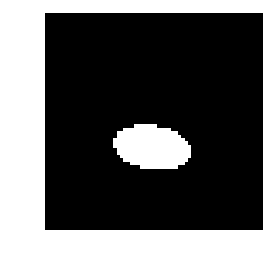

In [100]:

# testing scm functions
ox, y = get_specific_data(cuda=True)
mu, sigma = vae.encoder.forward(ox,vae.remap_y(y))
scm = SCM(vae, mu.cpu(), sigma.cpu())
print(y)
plot_image(x)

tensor([[ 0.,  0.,  5., 39., 20., 18.]], device='cuda:0')
tensor([[ 0.,  1.,  5., 39., 20., 18.]], device='cuda:0')


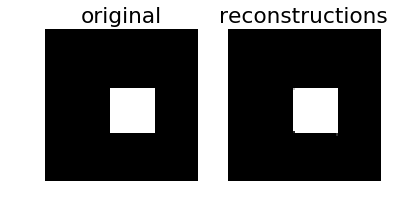

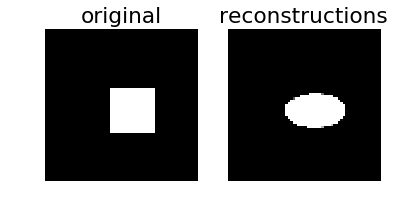

In [101]:
original, y_original = get_specific_data(cuda=True)
print(y_original)
mu, sigma = vae.encoder.forward(x,vae.remap_y(y_original))
B = 50
zs = torch.cat([dist.Normal(mu.cpu(), sigma.cpu()).sample() for a in range(B)], 0)
ys = torch.cat([vae.remap_y(y_original) for a in range(B)], 0)
rs = vae.decoder.forward(zs.cuda(), ys).detach()
compare_to_density(original,rs)

y_new = torch.tensor(y_original)
y_new[0,1] = (y[0,1] + 1) % 2
print(y_new)
zs = torch.cat([dist.Normal(mu.cpu(), sigma.cpu()).sample() for a in range(B)], 0)
ys = torch.cat([vae.remap_y(y_new) for a in range(B)], 0)
rs = vae.decoder.forward(zs.cuda(), ys).detach()
compare_to_density(original,rs)

In [104]:
cond_data = {}
for i in range(1, 6):
    cond_data["Y_{}".format(i)] = torch.tensor(y[0,i].cpu()).to(torch.float32)

cond_noise = scm.update_noise_svi(cond_data)

print(cond_noise)

step 0: loss of 78606.24
step 100: loss of 25246.26
step 200: loss of 56169.88
step 300: loss of 22165.04
step 400: loss of inf
step 500: loss of inf
{'N_X': Normal(loc: torch.Size([4096]), scale: torch.Size([4096])), 'N_Z': Normal(loc: torch.Size([50]), scale: torch.Size([50])), 'N_Y_1': Normal(loc: torch.Size([3]), scale: torch.Size([3])), 'N_Y_2': Normal(loc: torch.Size([6]), scale: torch.Size([6])), 'N_Y_3': Normal(loc: torch.Size([40]), scale: torch.Size([40])), 'N_Y_4': Normal(loc: torch.Size([32]), scale: torch.Size([32])), 'N_Y_5': Normal(loc: torch.Size([32]), scale: torch.Size([32]))}


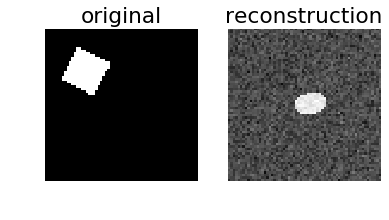

In [105]:
(rx,_,_), _ = scm.model(cond_noise)
compare_reconstruction(ox, rx)

## ======== Un charted territory  =======

In [0]:
vae.label_names

array(['color', 'shape', 'scale', 'orientation', 'posX', 'posY'],
      dtype='<U11')

In [32]:
adam_params = {"lr": 0.00042, "betas": (0.9, 0.999)}
optimizer = Adam(adam_params)
# set up the loss(es) for inference. wrapping the guide in config_enumerate builds
# the loss as a sum
# by enumerating each class label for the sampled discrete categorical distribution
# in the model
guide = config_enumerate(guide, "parallel", expand=True)
elbo = Trace_ELBO(max_plate_nesting=1)
loss_basic = SVI(sup_vae.model, guide, optimizer, loss=elbo)

# build a list of all losses considered
losses = [loss_basic]
loss_aux = SVI(sup_vae.model_classify, sup_vae.guide_classify, optimizer, loss=elbo)
losses.append(loss_aux)



from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO

adam = Adam({"lr": 0.005, "betas": (0.90, 0.999)})
svi = SVI(vae.model, vae.guide, adam, loss=Trace_ELBO())


param_vals = []
pbar = tqdm(range(5))
for _ in pbar:
  xs, ys = next(data_iter)
  xs = xs.cuda()
  ys = ys.cuda()
  svi.step(xs, ys)
#   param_vals.append({k: param(k).item() for k in ["fl", "ia"]})

# pd.DataFrame(param_vals).plot(subplots=True)


  0%|          | 0/5 [00:00<?, ?it/s]

StopIteration: ignored